Title: Othot Challenge

Author: Ziruo Zhang

Date: Febuary 2019


This is the analysis for the Churn data set, and the overall goal is to build a model to predict which customers leave and which customers stay for a fictional telecommunications firm. This note will start with EDA first, and build two binary classification models and access their performance. 



In [68]:
# Import the module needed 
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier)
from sklearn import preprocessing
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, 
                            roc_curve, auc)

import matplotlib.pyplot as plt
import seaborn as sns  

In [6]:
# Read the data
churn = pd.read_csv("churn.csv")

# explore the data 
print(churn.head(10))
# number of observations
print(churn.shape[0])
# number of variablesz
print(churn.shape[1])

churn.info()

  COLLEGE  INCOME  OVERAGE  LEFTOVER   HOUSE  HANDSET_PRICE  \
0    zero   31953        0         6  313378            161   
1     one   36147        0        13  800586            244   
2     one   27273      230         0  305049            201   
3    zero  120070       38        33  788235            780   
4     one   29215      208        85  224784            241   
5    zero  133728       64        48  632969            626   
6    zero   42052      224         0  697949            191   
7     one   84744        0        20  688098            357   
8    zero   38171        0         7  274218            190   
9    zero  105824      174        18  153560            687   

   OVER_15MINS_CALLS_PER_MONTH  AVERAGE_CALL_DURATION REPORTED_SATISFACTION  \
0                            0                      4                 unsat   
1                            0                      6                 unsat   
2                           16                     15                

10148

We can see that there are twelve variables and 20,000 observations, and we will briefly summarize the type of variables as below. There is no missing data according to the information of dataframe, so we don't need to worry about the potential problems caused by missingness.

### Predictors
- Catergorical(Binary):College; 
- Quantitative: Income, Overage, Leftover, House, Handset Price, OVER_15MINS_CALLS_PER_MONTH, AVERAGE_CALL_DURATION.
- Catergorical(Multi levels): REPORTED_SATISFACTION, Reported Usage Level, Considering Change of Plan. 

### Response Variable
- Leave - Catergorical(Binary): Whether the customer leaves or stays or not?

### Correlated Numerical Variables
Next, we will focus on the correlation between the numerical variables, from the correlation matrix, we know that there are three highly correlated pairs of variables, which is 'handset price' and 'income', 'over 15mins calls per month' and 'overage', and 'average call duration' and 'leftover'. 

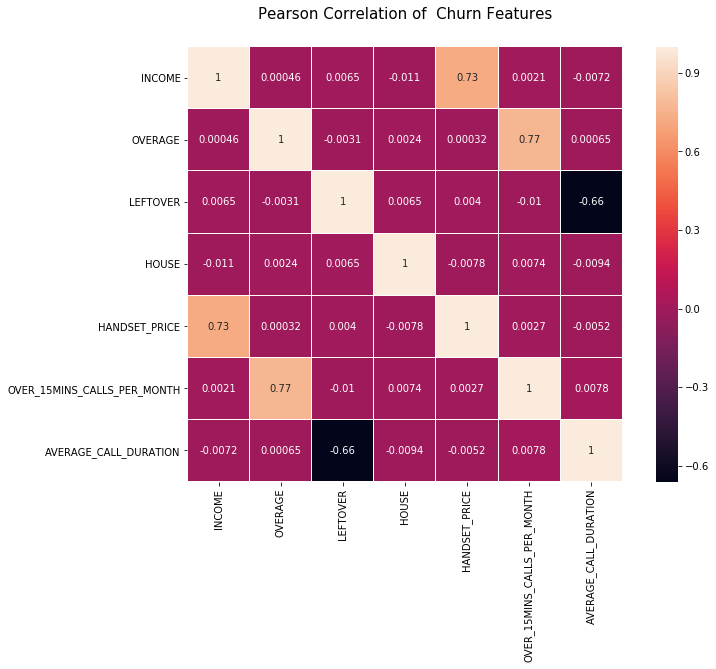

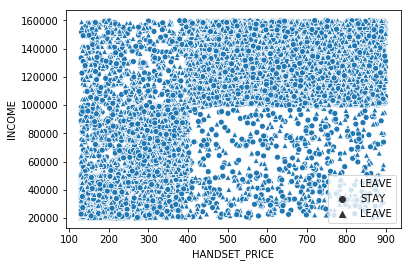

In [95]:
# Exploratory data analysis begins here

# Correlation Plot
data = churn.corr()  
plt.figure(figsize=(12,8))
plt.title('Pearson Correlation of  Churn Features',y=1.05,size=15)
sns.heatmap(data, linewidths=0.05,vmax=1.0,
            square=True,linecolor='white',annot=True)  
plt.show()



### Univariate Data Visualization
Next, we want to examine how does each variable influence the response variable - LEAVE. For the categorical variable, we are going to draw bar plot against the response variable; for the quantitative variable, we are going to draw histograms. In total we have 11 predictors, and the univariate graphical EDA is as below. From these plots, we can see that.. 

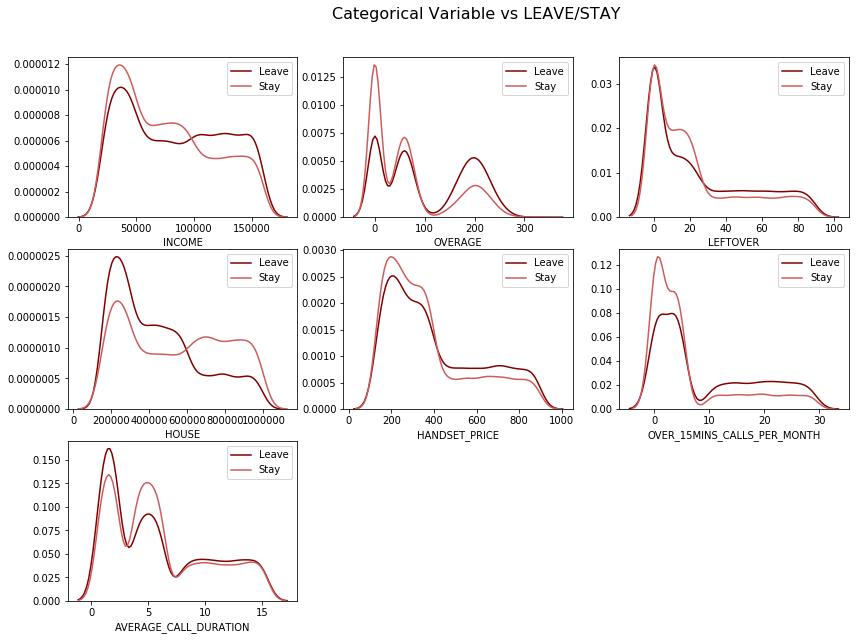

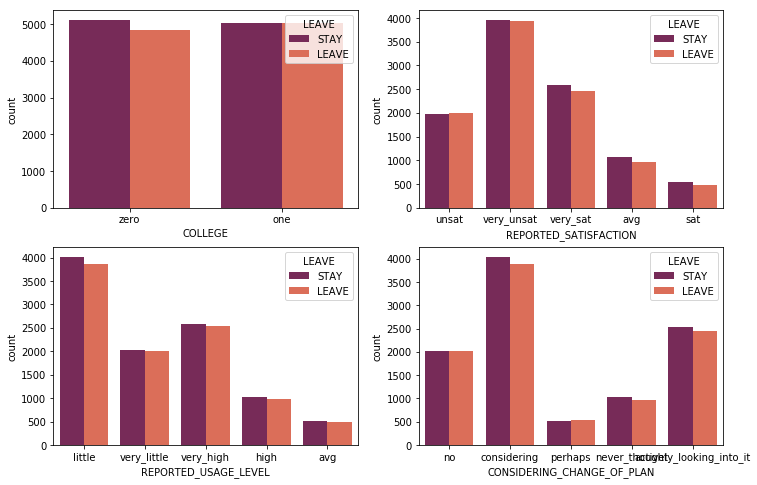

In [99]:
# The univariate EDA (regarding 'LEAVE')

churn_leave = churn[churn['LEAVE']=="LEAVE"]
churn_stay = churn[churn['LEAVE']=="STAY"]

cat_variable =["COLLEGE", "REPORTED_SATISFACTION", "REPORTED_USAGE_LEVEL", 
               "CONSIDERING_CHANGE_OF_PLAN"]
num_variable = ["INCOME", "OVERAGE", "LEFTOVER", "HOUSE", "HANDSET_PRICE", "OVER_15MINS_CALLS_PER_MONTH",
                "AVERAGE_CALL_DURATION"]
# Numerical Variable
plt.figure(figsize=(14,10))
plt.suptitle("Categorical Variable vs LEAVE/STAY",fontsize=16,x=0.53,y=0.95)
for i in range(len(num_variable)):
    plt.subplot(int('33'+str(i+1)))
    sns.distplot(churn_leave[num_variable[i]] , color="maroon", label="Leave", hist=False)
    sns.distplot(churn_stay[num_variable[i]] , color="indianred", label="Stay", hist=False)
    
# Categorical Variable
plt.figure(figsize=(12,8))
for i in range(len(cat_variable)):
    plt.subplot(int('22'+str(i+1)))
    sns.countplot(x=cat_variable[i], hue ="LEAVE", data=churn, palette="rocket")


### Split Training Set and Test Set 

Next, we will build two classification models to predict "LEAVE". Since the scikit-learn parkage cannnot take 

In [28]:
le = preprocessing.LabelEncoder()
labelchurn = churn.apply(le.fit_transform)

# Divide the original data set into predictors and response variable
churn_X = labelchurn.drop(columns=['LEAVE'])
churn_y = labelchurn["LEAVE"]

# Generate training set and test set
X_train, X_test, y_train, y_test = train_test_split(churn_X, churn_y, test_size=0.2)

### Logistic Model

For the first model, the training set will be fixed using logistic regression. 

0.62625
[[1233  764]
 [ 731 1272]]
              precision    recall  f1-score   support

           0       0.62      0.63      0.62      1964
           1       0.64      0.62      0.63      2036

   micro avg       0.63      0.63      0.63      4000
   macro avg       0.63      0.63      0.63      4000
weighted avg       0.63      0.63      0.63      4000



Text(0, 0.5, 'Frequency')

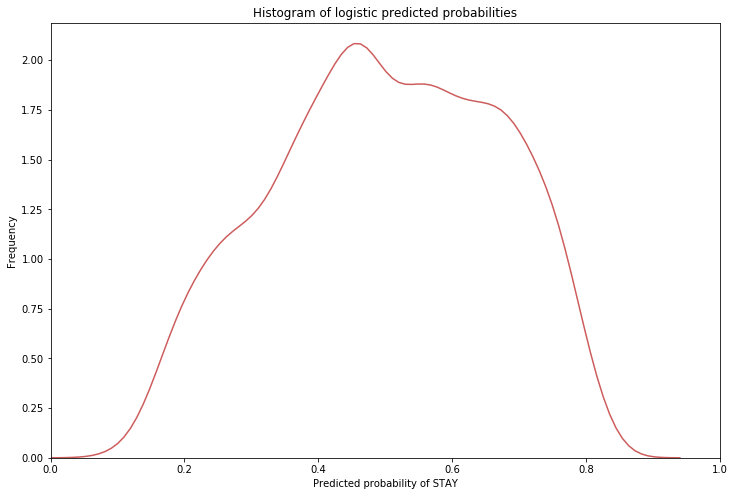

In [142]:
# Build the first binary model

# Logistic regression

lgmodel = LogisticRegression(penalty='l2', solver='liblinear').fit(X_train, y_train)
# Returns the mean accuracy on the given test data and labels.
score = lgmodel.score(X_test, y_test)
print(score)


# Make prediction on the training set
lgpredict = lgmodel.predict(X_test)
lg_confusion_matrix = confusion_matrix(lgpredict, y_test)
print(lg_confusion_matrix)
print(classification_report(y_test, lgpredict))

# store the predicted probabilities for class 1 (stay)
y_pred_prob = lgmodel.predict_proba(X_test)[:, 1]

plt.figure(figsize=(12,8))
sns.distplot(y_pred_prob , color="indianred", hist=False)

plt.xlim(0,1)
plt.title('Histogram of logistic predicted probabilities')
plt.xlabel('Predicted probability of STAY')
plt.ylabel('Frequency')

### Classification Tree and Random Forest
    
    
Then we will consider building a random forest to make the prediction.

In [141]:
# Decision tree and random forest
rf = RandomForestClassifier(n_estimators=200, max_depth=4,
                             random_state=0)
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_train, y_train, cv=5)
print(scores)


[0.70321774 0.69946892 0.6946875  0.69302907 0.69396686]


### Feature Importance

Feature ranking:
1. feature 4 (0.350335)
2. feature 2 (0.252160)
3. feature 6 (0.126900)
4. feature 1 (0.096636)
5. feature 3 (0.067455)
6. feature 5 (0.064084)
7. feature 7 (0.038541)
8. feature 9 (0.001117)
9. feature 8 (0.000974)
10. feature 10 (0.000919)
11. feature 0 (0.000879)


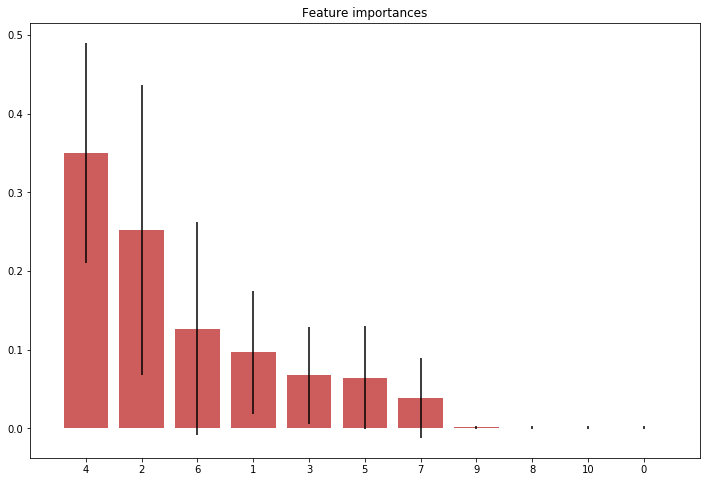

[[1377  685]
 [ 587 1351]]
              precision    recall  f1-score   support

           0       0.70      0.63      0.66      1964
           1       0.67      0.74      0.71      2036

   micro avg       0.69      0.69      0.69      4000
   macro avg       0.69      0.68      0.68      4000
weighted avg       0.69      0.69      0.68      4000



In [143]:
importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="indianred", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


rfpredict = rf.predict(X_test)
rf_confusion_matrix = confusion_matrix(gbtpredict, y_test)
print(rf_confusion_matrix)
print(classification_report(y_test, rfpredict))



In [63]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
print(cv)

ShuffleSplit(n_splits=5, random_state=0, test_size=0.3, train_size=None)


### Gradient Boosting Tree

Next, we will use gradient boosting tree to compare the perfomance of random forest, whch


In [ ]:
gbt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
      max_depth=2, random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))

gbtpredict = gbt.predict(X_test)
gbt_confusion_matrix = confusion_matrix(gbtpredict, y_test)
print(gbt_confusion_matrix)
print(classification_report(y_test, gbtpredict))


In [ ]:
### Feature Importance

[0.00114886 0.22469321 0.33283952 0.0907191  0.29138571 0.0283667
 0.0181346  0.00183114 0.00154281 0.00310397 0.00623438]
Feature ranking:
1. feature 2 (0.332840)
2. feature 4 (0.291386)
3. feature 1 (0.224693)
4. feature 3 (0.090719)
5. feature 5 (0.028367)
6. feature 6 (0.018135)
7. feature 10 (0.006234)
8. feature 9 (0.003104)
9. feature 7 (0.001831)
10. feature 8 (0.001543)
11. feature 0 (0.001149)


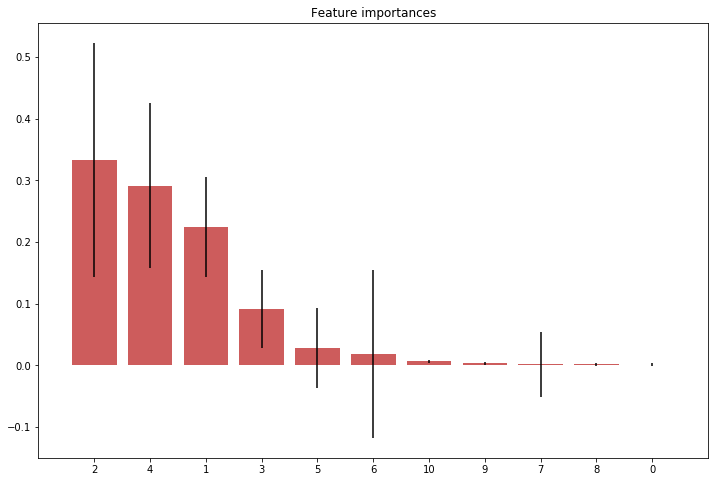

In [144]:
importances = gbt.feature_importances_
print(importances)


std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="indianred", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


### Model Comparision

<Figure size 432x288 with 0 Axes>

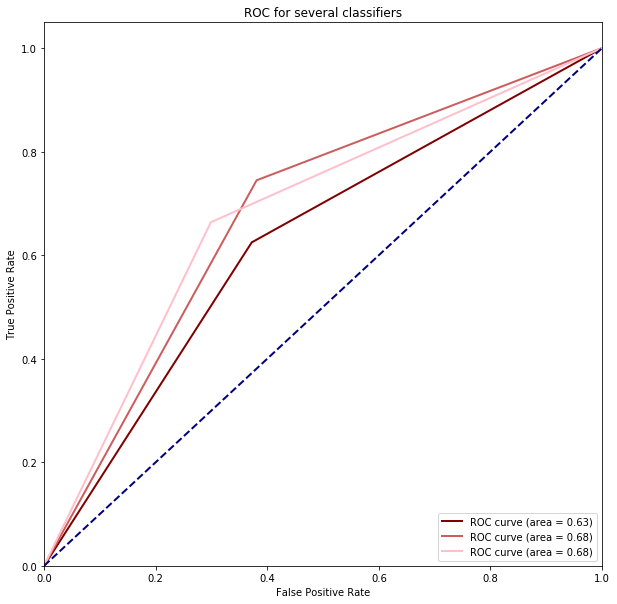

In [110]:
# access and compare model's performance

# the base rate (for naive classifier)
print("Naive Rate", sum(churn["LEAVE"] == "STAY")/20000)

# ROC curve
# Logistic
lgfpr,lgtpr,lgthreshold = roc_curve(y_test, lgpredict) 
lgroc_auc = auc(lgfpr,lgtpr)

# Random Forest
rffpr, rftpr, rfthreshold = roc_curve(y_test, rfpredict) 
rfroc_auc = auc(rffpr,rftpr)

# Gradient Boosting Tree
gbtfpr, gbttpr, gbtthreshold = roc_curve(y_test, gbtpredict) 
gbtroc_auc = auc(gbtfpr,gbttpr)

plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(lgfpr, lgtpr, color='maroon',
         lw=lw, label='ROC curve (area = %0.2f)' % lgroc_auc)
plt.plot(rffpr, rftpr, color='indianred',
         lw=lw, label='ROC curve (area = %0.2f)' % rfroc_auc)
plt.plot(gbtfpr, gbttpr, color='pink',
         lw=lw, label='ROC curve (area = %0.2f)' % gbtroc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for several classifiers')
plt.legend(loc="lower right")
plt.show()

Assess the performance of the model(s). Make sure to interpret and explain the results.



### Summary

